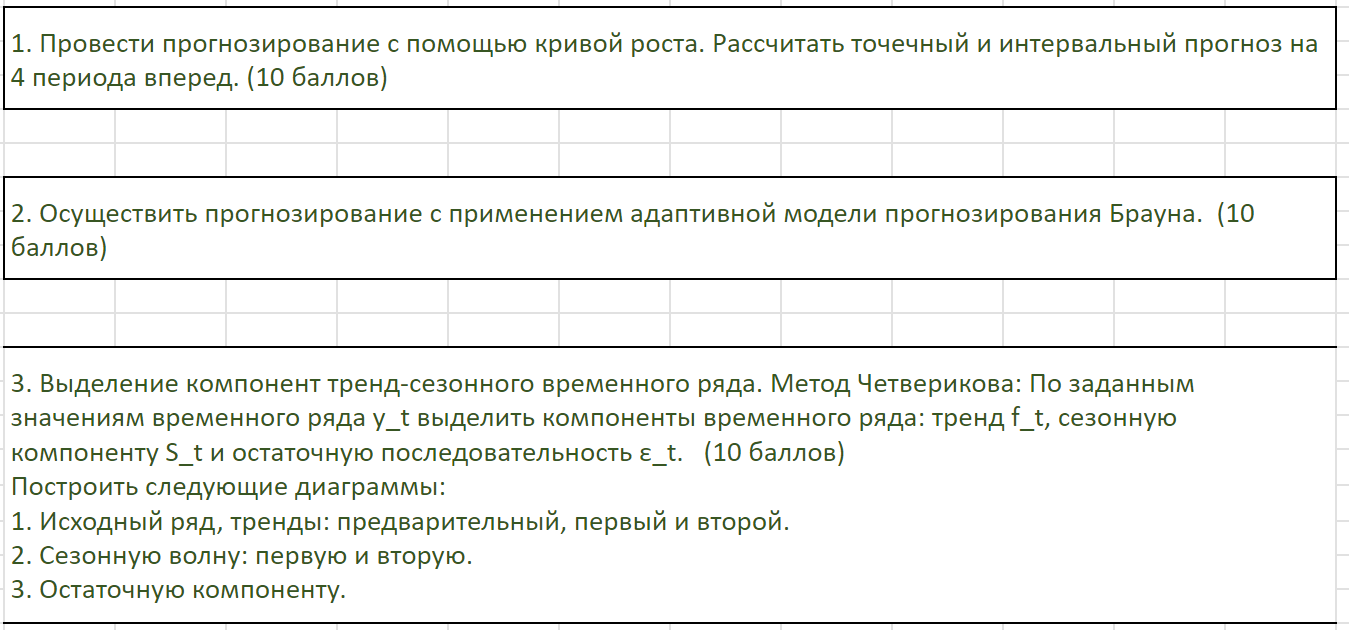

In [ ]:
# Данный прототип относится к вариантам [2, 5, 7, 8, 23, 24]

VARIANT = 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import interpolate
from scipy.stats import t
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
df = pd.read_excel(
    'Задача экзамен ПМ20-4.xlsx',
    sheet_name='Вариант2',
    decimal=',',
    skiprows=[1]
)
df = df.iloc[:, :2]

index = pd.date_range(start='2008', end='2022', freq='Q')
df = df.set_index(index)
df["T"] = np.arange(1, len(df["T"])+1)

df

,T,INVFC_Q_DIRI
2008-03-31,1,107.5
2008-06-30,2,156.2
2008-09-30,3,175.6
2008-12-31,4,223.7
2009-03-31,5,88.2
2009-06-30,6,123.7
2009-09-30,7,144.6
2009-12-31,8,203.1
2010-03-31,9,83.9
2010-06-30,10,130.5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 2008-03-31 to 2021-12-31
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   T             56 non-null     int64  
 1   INVFC_Q_DIRI  56 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.3 KB


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['INVFC_Q_DIRI'],
                    mode='lines+markers',
                    name='Исходный ряд')
)

fig.update_layout(title='Исходный ряд', width=1000, height=700)
fig.show()

## Задание №1. Кривая роста

**1. Провести прогнозирование с помощью кривой роста. Рассчитать точечный и интервальный прогноз на 4 периода вперед. (10 баллов)**

В моём варианте лучше всего выбрать сезонную кривую роста, т.к. данные во временном ряду имеют выраженную сезонность. Сезонная кривая роста отражает повторяющиеся события в данных, которые связаны с сезонностью (в моём случае ежеквартальные среднедушевые денежные доходы населения).

На графике видно, что присутствует восходящий тренд, а также сезонность.

Проверим есть ли сезонность в данных, используя декомпозицию:

**Вывод: В данном случае, лучше всего выбрать аддитивную модель, так как изменения в тренде и сезонности в течение времени примерно остаются на одном уровне и имеют небольшую абсолютную величину.**

In [ ]:
def get_seasonal_decompose(model_type: str):
    """ model_type = ["additive", "multiplicative"] """

    decompose_result = seasonal_decompose(df.INVFC_Q_DIRI, model=model_type)

    fig = make_subplots(rows=4, cols=1)

    fig.add_trace(
        go.Scatter(x=df.index, y=decompose_result.observed, mode='lines+markers', name='Исходный ряд'),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=df.index, y=decompose_result.trend, mode='lines', name='Тренд'),
        row=2, col=1
    )

    fig.add_trace(
        go.Scatter(x=df.index, y=decompose_result.seasonal, mode='lines', name='Сезонность'),
        row=3, col=1
    )

    fig.add_trace(
        go.Scatter(x=df.index, y=decompose_result.resid, mode='markers', name='Случайные ошибки'),
        row=4, col=1
    )

    fig.update_layout(height=600, width=800, title_text=f"Аналитика по временному ряду ({model_type} model)")
    fig.show()

In [ ]:
get_seasonal_decompose(model_type="additive")
get_seasonal_decompose(model_type="multiplicative")

In [ ]:
def get_curve(formula: str):
    model_1 = sm.OLS.from_formula(formula, data=df).fit()

    e = model_1.resid
    new_mean_growth = []
    for ost in range(len(e)-1):
        new_mean_growth.append((e[ost+1] + e[ost])/2)
    delta_yt = np.sum(new_mean_growth)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df.index, y=df['INVFC_Q_DIRI'],
                        mode='lines+markers',
                        name='Исходный ряд')
    )

    fig.add_trace(go.Scatter(x=df.index, y=model_1.fittedvalues,
                        mode='lines+markers',
                        name=f'∆𝑦_𝑡 = {delta_yt}')
    )

    fig.update_layout(title='Сравнение исходного ряда и модели')
    fig.show()

    return model_1


In [ ]:
formula = 'INVFC_Q_DIRI ~ T'
first_model = get_curve(formula)

In [ ]:
df['T_SQUARE'] = df[['T']] ** 2
formula = 'INVFC_Q_DIRI ~ T + T_SQUARE'
second_model = get_curve(formula)

In [ ]:
df['T_CUBE'] = df[['T']] ** 3
formula = 'INVFC_Q_DIRI ~ T + T_SQUARE + T_CUBE'
third_model = get_curve(formula)

In [ ]:
df['T_FOURTH'] = df[['T']] ** 4
formula = 'INVFC_Q_DIRI ~ T + T_SQUARE + T_CUBE + T_FOURTH'
fourth_model = get_curve(formula)

In [ ]:
formula = 'INVFC_Q_DIRI ~ np.exp(T)'
fifth_model = get_curve(formula)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['INVFC_Q_DIRI'],
                    mode='lines+markers',
                    name='Исходный ряд')
)

fig.add_trace(go.Scatter(x=df.index, y=first_model.fittedvalues,
                    mode='lines+markers',
                    name='first_model')
)

fig.add_trace(go.Scatter(x=df.index, y=second_model.fittedvalues,
                    mode='lines+markers',
                    name='second_model')
)

fig.add_trace(go.Scatter(x=df.index, y=third_model.fittedvalues,
                    mode='lines+markers',
                    name='third_model')
)

fig.add_trace(go.Scatter(x=df.index, y=fourth_model.fittedvalues,
                    mode='lines+markers',
                    name='fourth_model')
)

fig.update_layout(title='Сравнение исходного ряда и кривых роста', width=1100, height=650)

fig.show()

In [ ]:
def get_exog(model, n):
    T = np.arange(model.nobs+1, model.nobs+n+1)
    T_SQUARE, T_CUBE, T_FOURTH = T**2, T**3, T**4

    dataframe = pd.DataFrame(data={"T": T, "T_SQUARE": T_SQUARE, "T_CUBE": T_CUBE, "T_FOURTH": T_FOURTH})
    return dataframe

In [ ]:
n_periods = 4
new_index = pd.date_range(start='2022', periods=n_periods, freq='Q')

forecast = fourth_model.get_prediction(exog=get_exog(fourth_model, n_periods), transform=True)

mean_forecast = forecast.summary_frame()
mean_forecast

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,233.308060,44.808927,143.350386,323.265734,82.944023,383.672097
1,247.348487,55.170625,136.588835,358.108138,83.688287,411.008687
2,263.040453,67.300587,127.928887,398.152020,82.009804,444.071103
3,280.491530,81.276417,117.322315,443.660745,77.658708,483.324351


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['INVFC_Q_DIRI'],
                    mode='lines+markers',
                    name='Исходный ряд')
)

fig.add_trace(go.Scatter(x=df.index, y=fourth_model.fittedvalues,
                    mode='lines+markers',
                    name='fourth_model')
)

fig.add_trace(go.Scatter(x=new_index, y=forecast.predicted,
                    mode='lines+markers',
                    name='forecast')
)

fig.add_trace(go.Scatter(x=new_index, y=mean_forecast['mean_ci_upper'],
                    mode='lines+markers',
                    name='upper bound')
)

fig.add_trace(go.Scatter(x=new_index, y=mean_forecast['mean_ci_lower'],
                    mode='lines+markers',
                    name='lower bound')
)

fig.update_layout(title='Сравнение исходного ряда и предсказания', width=1100, height=650)

fig.show()

## Задание №2.1. Модель Хольта-Уинтерса

**Моделирование тренд-сезонных процессов. Применить Модель Хольта-Уинтерса. (10 баллов)**

In [ ]:
seasonal_m = 4
alpha = 1 / (2 * seasonal_m)

init_val = df['INVFC_Q_DIRI']

level_1 = SimpleExpSmoothing(init_val).fit(smoothing_level=alpha, optimized=False, use_brute=True).fittedvalues

level_2_add = ExponentialSmoothing(init_val, trend='add').fit().fittedvalues
level_2_mul = ExponentialSmoothing(init_val, trend='mul').fit().fittedvalues

level_3_add = ExponentialSmoothing(init_val, trend='add', seasonal='add', seasonal_periods=4).fit().fittedvalues
level_3_mul = ExponentialSmoothing(init_val, trend='mul', seasonal='mul', seasonal_periods=4).fit().fittedvalues

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning:

overflow encountered in matmul



In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['INVFC_Q_DIRI'],
                    mode='lines+markers',
                    name='Исходный ряд')
)

fig.add_trace(go.Scatter(x=df.index, y=level_1,
                    mode='lines+markers',
                    name='level_1')
)

fig.add_trace(go.Scatter(x=df.index, y=level_2_add,
                    mode='lines+markers',
                    name='level_2_add')
)

fig.add_trace(go.Scatter(x=df.index, y=level_2_mul,
                    mode='lines+markers',
                    name='level_2_mul')
)

fig.add_trace(go.Scatter(x=df.index, y=level_3_add,
                    mode='lines+markers',
                    name='level_3_add')
)

fig.add_trace(go.Scatter(x=df.index, y=level_3_mul,
                    mode='lines+markers',
                    name='level_3_mul')
)

fig.update_layout(title='Экспоненциальное сглаживание', width=1300, height=750)

fig.show()

In [ ]:

fitted_model = ExponentialSmoothing(df['INVFC_Q_DIRI'][:-4], trend='mul', seasonal='mul', seasonal_periods=4).fit()
test_predictions = fitted_model.forecast(4) # прогноз для 4 будущих периодов


fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['INVFC_Q_DIRI'],
                    mode='lines+markers',
                    name='Исходный ряд')
)

fig.add_trace(go.Scatter(x=df.index[:-4], y=fitted_model.fittedvalues,
                    mode='lines+markers',
                    name='Model')
)

fig.add_trace(go.Scatter(x=df.index[-4:], y=test_predictions,
                    mode='lines+markers',
                    name='Forecast')
)


fig.update_layout(title='Экспоненциальное сглаживание forecast', width=1300, height=750)

fig.show()

## Задание №2.2. Модель Брауна

**Осуществить прогнозирование с применением адаптивной модели прогнозирования Брауна. (10 баллов)**

In [ ]:
def brown_single(data, alpha):
    forecast = np.zeros(len(data))
    level = np.zeros(len(data))
    error = np.zeros(len(data))

    level[0] = data[0]
    error[0] = data[1] - data[0]
    forecast[0] = data[0] - 3

    for i in range(1, len(data)):
        if i == 1:
            level[i] = data[i]
            error[i] = data[i] - data[i-1]
        else:
            level[i] = alpha * data[i] + (1 - alpha) * level[i-1]
            error[i] = alpha * (data[i] - data[i-1]) + (1 - alpha) * error[i-1]

        forecast[i] = level[i] + error[i]

    return forecast, level, error


alpha = 0.4
data = df.INVFC_Q_DIRI
n = len(data)

forecast, level, error = brown_single(data, alpha)

sse = np.sum(error**2)
std_error = np.sqrt(sse / (n-2))
coeff = t.isf(0.05/2, n-1)

upper_border = forecast - coeff*std_error
bottom_border = forecast + coeff*std_error

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df.INVFC_Q_DIRI,
                    mode='lines+markers',
                    name='Исходный ряд')
)

fig.add_trace(go.Scatter(x=df.index, y=forecast,
                    mode='lines+markers',
                    name='Forecast')
)

fig.add_trace(go.Scatter(x=df.index, y=upper_border,
                    fill=None,
                    mode='lines',
                    line_color=px.colors.qualitative.Pastel1[1],
                    name='Верхняя граница доверительного интервала')
)

fig.add_trace(go.Scatter(x=df.index, y=bottom_border,
                    fill="tonexty",
                    mode='lines',
                    line_color=px.colors.qualitative.Pastel1[1],
                    name='Верхняя граница доверительного интервала')
)


fig.update_layout(title=f'Адаптивная модель Брауна (α={alpha})', width=1300, height=750)

fig.show()

## Задание №3. Метод Четверикова

**Выделение компонент тренд-сезонного временного ряда. Метод Четверикова: По заданным значениям временного ряда y_t выделить компоненты временного ряда: тренд f_t, сезонную компоненту S_t и остаточную последовательность ε_t. (10 баллов)**

**Построить следующие диаграммы:**
- Исходный ряд, тренды: предварительный, первый и второй.
- Сезонную волну: первую и вторую.
- Остаточную компоненту


In [ ]:
cycle, trend = sm.tsa.filters.hpfilter(x=df.INVFC_Q_DIRI, lamb=1600)
res = sm.tsa.seasonal_decompose(df.INVFC_Q_DIRI, model='additive', period=4)

previous_trend = cycle
first_trend = trend
second_trend = res.trend

first_seasonal = res.seasonal[:4]
second_seasonal = res.seasonal[4:8]

error_component = res.resid

In [ ]:
fig = make_subplots(rows=7, cols=1)


fig.add_trace(
    go.Scatter(x=df.index, y=df.INVFC_Q_DIRI, mode='lines+markers', name='Изначальный ряд'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df.index, y=previous_trend, mode='lines+markers', name='Предварительный тренд'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=df.index, y=first_trend, mode='lines', name='Первый тренд'),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=df.index, y=second_trend, mode='lines', name='Второй тренд'),
    row=4, col=1
)

fig.add_trace(
    go.Scatter(x=first_seasonal.index, y=first_seasonal, mode='lines+markers', name='Первая сезонная волна'),
    row=5, col=1
)

fig.add_trace(
    go.Scatter(x=second_seasonal.index, y=second_seasonal, mode='lines+markers', name='Вторая сезонная волна'),
    row=6, col=1
)

fig.add_trace(
    go.Scatter(x=df.index, y=error_component, mode='lines', name='Остаточная компонента'),
    row=7, col=1
)

fig.update_layout(height=900, width=1400, title_text="Выделение тренд-сезонного временного ряда по Четверикову")
fig.show()